# Relax Challenge

objective: 
- identify which factors predict future user adoption

Approach:
- Identify 'adopted users' based on the definition provided in the brief
- Create a target variable with binary values for adoption (True or False)
- Clean and transform data
- Assess features of importance
- Derive recommendations

## Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

## Loading and checking data

In [2]:
features = pd.read_csv('takehome_users.csv')
adoption = pd.read_csv('takehome_user_engagement.csv')

In [3]:
features.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
adoption.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
adoption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
# Verifying that all interactions in adoption table are true
adoption.visited.unique()

array([1])

In [8]:
adoption.shape

(207917, 3)

## Step 1: Identify adopted users

From the brief, an "adopted user" is a user who has logged into the product on three separate days in at least one seven day period

In [9]:
# converting the time_stamp into datetime object
adoption['time_stamp'] = pd.to_datetime(adoption['time_stamp'])
adoption.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [10]:
# Identifying the time range that constitute the past 7 days
past7days = max(adoption.time_stamp) - timedelta(days = 7)
print('Last transaction was done on {}'.format(max(adoption.time_stamp)))
print('The 7 days period start on'.format(past7days))

Last transaction was done on 2014-06-06 14:58:50
The 7 days period start on


In [11]:
# Filter the data frame for transactions that were done during the past 7 days
adoption['active_7days'] = np.where(adoption['time_stamp'] >= past7days, True, False)
adoption

,time_stamp,user_id,visited,active_7days
0,2014-04-22 03:53:30,1,1,False
1,2013-11-15 03:45:04,2,1,False
2,2013-11-29 03:45:04,2,1,False
3,2013-12-09 03:45:04,2,1,False
4,2013-12-25 03:45:04,2,1,False
...,...,...,...,...
207912,2013-09-06 06:14:15,11996,1,False
207913,2013-01-15 18:28:37,11997,1,False
207914,2014-04-27 12:45:16,11998,1,False
207915,2012-06-02 11:55:59,11999,1,False


In [12]:
# Creating a new feature to record the total number of transations by users
visited = adoption.groupby('user_id').agg({'visited': 'sum'})

In [13]:
# Breaking down the timestamp into year, month, week and days for more features
adoption['year'] = pd.DatetimeIndex(adoption['time_stamp']).year
adoption['month'] = pd.DatetimeIndex(adoption['time_stamp']).month
adoption['week'] = pd.DatetimeIndex(adoption['time_stamp']).weekday
adoption['day'] = pd.DatetimeIndex(adoption['time_stamp']).day

In [14]:
# Subsetting the df to select only users having been active over the past 7 days
active = adoption[adoption['active_7days'] == True]

In [15]:
active

,time_stamp,user_id,visited,active_7days,year,month,week,day
299,2014-05-30 22:08:03,10,1,True,2014,5,4,30
300,2014-05-31 22:08:03,10,1,True,2014,5,5,31
301,2014-06-01 22:08:03,10,1,True,2014,6,6,1
302,2014-06-02 22:08:03,10,1,True,2014,6,0,2
303,2014-06-03 22:08:03,10,1,True,2014,6,1,3
...,...,...,...,...,...,...,...,...
207254,2014-05-30 23:34:12,11959,1,True,2014,5,4,30
207255,2014-05-31 23:34:12,11959,1,True,2014,5,5,31
207256,2014-06-01 23:34:12,11959,1,True,2014,6,6,1
207504,2014-05-31 08:12:37,11967,1,True,2014,5,5,31


In [16]:
# Creating a list to store all the users having been active over 3 distinct days over 
# the past 7 days

adopted_users = []
users = active.user_id.unique()
days = active.day.unique()

for user in users:
    transactions = active[active['user_id'] == user]
    if len(transactions.day.unique()) >=3:
        adopted_users.append(user)
                        

In [17]:
# Summarizing findings from this step
print('Total number of users is: {}'.format(len(adoption.user_id.unique())))
print('The total number of active users is: {}'.format(len(active.user_id.unique())))
print('The total number of adopted users is: {}'.format(len(adopted_users)))
print('The proportion of adopted active users is: {}'.format(len(adopted_users)/len(active.user_id.unique())))

Total number of users is: 8823
The total number of active users is: 839
The total number of adopted users is: 403
The proportion of adopted active users is: 0.4803337306317044


## Step 2: Create a target variable with binary values for adoption 

In this step we will be merging the the 3 dataset constructed so far (adopted_users, features and visited) into a single dataframe having both features and target variable

In [18]:
# Transforming the adopted_users list into a dataframe
adopted_users_df = pd.DataFrame(adopted_users, columns = ['user_id'])
adopted_users_df['adoption'] = True
adopted_users_df

,user_id,adoption
0,10,True
1,63,True
2,82,True
3,146,True
4,185,True
...,...,...
398,11869,True
399,11885,True
400,11895,True
401,11924,True


In [19]:
merged = pd.merge(left = features, right = adopted_users_df, how = 'left', left_on = 'object_id', right_on = 'user_id')

In [20]:
merged = pd.merge(left = merged, right = visited, how = 'left', left_on = 'object_id', right_on = 'user_id')

In [21]:
merged.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adoption,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN,NaN,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,NaN,NaN,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN,NaN,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN,NaN,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN,NaN,1.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,NaN,NaN,1.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,NaN,NaN,1.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN,NaN,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,10.0,True,284.0


## Step 3: Cleaning and transforming data

In [22]:
# Checking NaN values prior to cleaning
merged.isnull().sum()

object_id                         0
creation_time                     0
name                              0
email                             0
creation_source                   0
last_session_creation_time     3177
opted_in_to_mailing_list          0
enabled_for_marketing_drip        0
org_id                            0
invited_by_user_id             5583
user_id                       11597
adoption                      11597
visited                        3177
dtype: int64

Overview of cleaning and transformation tasks:
- Drop name, email (not required for the modelling) and user_id (duplicate of object_id)
- Change type of creation_time & last_session_creation_time respectively from object and float to datetime
- Replace NaN for the following columns: 
    - Adoption nan: False 
    - last_session_creation_time NaN: 0
    - invited_by_user_id NaN: 0
    - visited NaN: 0
- Create a new feature 'duration' having how long users have been signed off for between the time they subscribed and their last session
- Use one hot encoder on adoption & creation_source which are categorical data

In [23]:
# Dropping unuseful data
data = merged.drop(['name', 'email', 'user_id'], axis = 1)

In [24]:
# Filling NaN values
data.adoption.fillna('False', inplace = True)
data.last_session_creation_time.fillna(0, inplace = True)
data.invited_by_user_id.fillna(0, inplace = True)
data.visited.fillna(0, inplace = True)

In [25]:
# Converting to datetime
data['creation_time'] = pd.to_datetime(data['creation_time'])
data['last_session_creation_time'] = pd.to_datetime(data['last_session_creation_time'], unit = 's')

In [26]:
# Adding duration
data['duration'] = ((data['last_session_creation_time'] - data['creation_time']) / np.timedelta64(1, 'D')).astype(int)

In [27]:
# Checking that there is no more null values
data.isnull().sum()

object_id                     0
creation_time                 0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adoption                      0
visited                       0
duration                      0
dtype: int64

In [28]:
# Checking that all values are now in the right type
data.dtypes

object_id                              int64
creation_time                 datetime64[ns]
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
adoption                              object
visited                              float64
duration                               int64
dtype: object

In [29]:
# Transforming categorical data
t_data = pd.get_dummies(data, drop_first = True)

In [30]:
t_data

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,duration,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,adoption_False
0,1,2014-04-22 03:53:30,2014-04-22 03:53:30,1,0,11,10803.0,1.0,0,0,0,0,0,1
1,2,2013-11-15 03:45:04,2014-03-31 03:45:04,0,0,1,316.0,14.0,136,1,0,0,0,1
2,3,2013-03-19 23:14:52,2013-03-19 23:14:52,0,0,94,1525.0,1.0,0,1,0,0,0,1
3,4,2013-05-21 08:09:28,2013-05-22 08:09:28,0,0,1,5151.0,1.0,1,0,0,0,0,1
4,5,2013-01-17 10:14:20,2013-01-22 10:14:20,0,0,193,5240.0,1.0,5,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,2013-09-06 06:14:15,0,0,89,8263.0,1.0,0,1,0,0,0,1
11996,11997,2013-01-10 18:28:37,2013-01-15 18:28:37,0,0,200,0.0,1.0,5,0,0,0,1,1
11997,11998,2014-04-27 12:45:16,2014-04-27 12:45:16,1,1,83,8074.0,1.0,0,0,0,0,0,1
11998,11999,2012-05-31 11:55:59,2012-06-02 11:55:59,0,0,6,0.0,1.0,2,0,1,0,0,1


## Step 4:  Extracting features of importance

<AxesSubplot:>

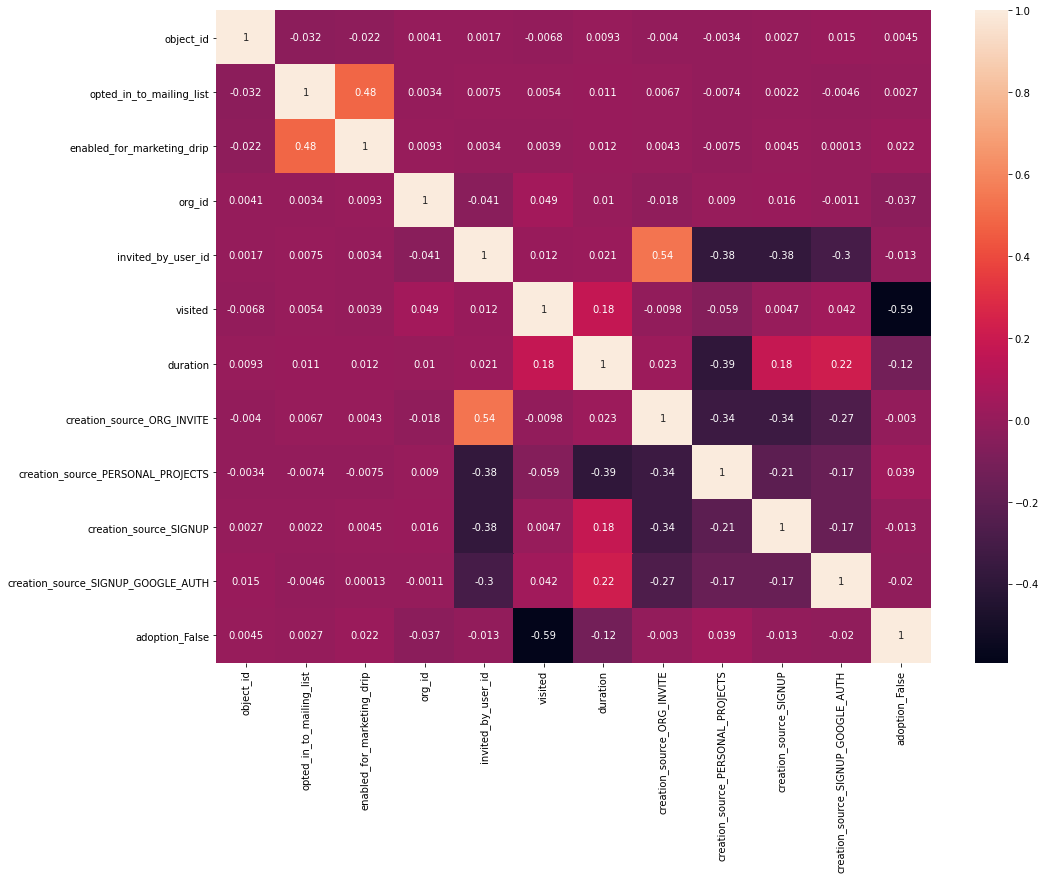

In [31]:
# Assessing correlation between variables
plt.figure(figsize = (16,12))
sns.heatmap(t_data.corr(), annot = True)

Without surprise, the frequency of visits and duration since signup are the most important predictors of adoption. Others factors are not so obvious and a deeper analysis is required to assess their level of importance

There are some level of collinearity between several features

In [32]:
# split data into train and test 
X = t_data.drop(['object_id','adoption_False','creation_time', 'last_session_creation_time'], axis = 1)
y = t_data['adoption_False']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
# Scale data before fitting into the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Using Linear Regression to weight features

In [34]:
# Instantiating the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [35]:
# Extracting features of importance
importances = pd.DataFrame(data = {'Attribute':X_train.columns, 'Importance':model.coef_[0]})
importances.sort_values(by = 'Importance', ascending = False)

,Attribute,Importance
1,enabled_for_marketing_drip,0.263315
0,opted_in_to_mailing_list,-0.092416
6,creation_source_ORG_INVITE,-0.131855
9,creation_source_SIGNUP_GOOGLE_AUTH,-0.136239
2,org_id,-0.136455
8,creation_source_SIGNUP,-0.200703
3,invited_by_user_id,-0.231242
7,creation_source_PERSONAL_PROJECTS,-0.309298
4,visited,-0.840414
5,duration,-2.409723


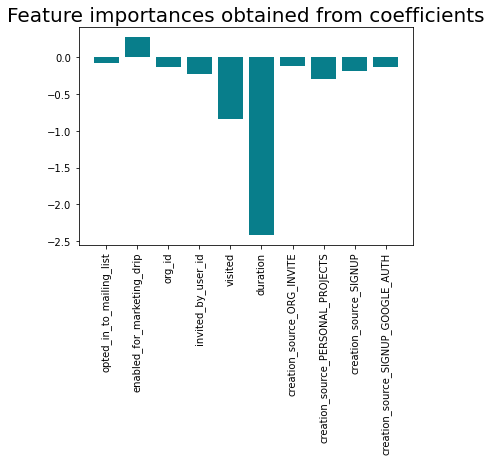

In [36]:
# Getting a visualization of the factors weights
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Using PCA to explain variance

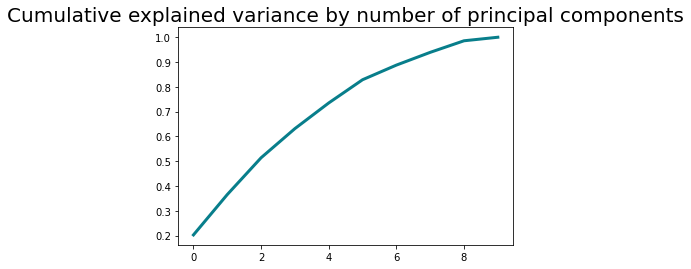

In [37]:
# Instantiating PCA
pca = PCA().fit(X_train_scaled)

# Plotting the explained variance
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

## Conclusions

- **The problem**
- Only 48% of active users have fully adopted the service. There is an opportunity to increase the frequency of use for infrequent users and hence, provide more value to the business.

- **The approach**
Understanding what are the most important features that determine adoption. We used the following steps to solve the problem:
    - Identify 'adopted users' based on the definition provided in the brief
    - Create a target variable with binary values for adoption (True or False)
    - Clean and transform data using one hot encoding for categorical data and StandardScaler 
    - Assess features of importance using 2 approaches:
        - Logistic Regression: simple model building on correlation matrix to extract features of importance. Our target features is binary, so good fit for this model
        - PCA: helped to reduce the collinearity effect while providing the cumulative level of explained variance in complement of the logistic regression
    - Derive recommendations

- **Key findings**
    - How long a user has been active for is the key factor that determine their adoption
    - Also, their frequency of visit of the platform is a good indicator as well
    - enabled_for_marketing_drip tend to produce more adopted users
    - creation_source_SIGNUP_GOOGLE_AUTH tend not to produce adopted users
    - A total of 6 features (org_id and creation_source_SIGNUP on top of the 4 mentioned above) are able to explain most of the variance. In summary 60% of factors can explain up to 90% of the variance. These factors should be the focus for action
    
- **Recommendations**
    - Incentivize infrequent users to be more active
    - Encourage users to sign up for the marketing email list
    
- **Further works**
    - A step forward to predict adoption based on features extracted from this work. This will help to anticipate earlier if a user is likely to be an adopter or not and based on that actions can be taken upfront
    - It could also be interesting to have users feedback of the service (under the form of rating for instance). This may enrich the model by providing additional information is a user is likely to be engaged and henced be more frequent or not